Satellite Coverage ML Demo
Training: 100 samples
Testing: 10 samples
MAE: 1.89
R²: 0.967

 Predictions:
---------------------------------------------------------------------------
Altitude     Inclin       Sats       Actual       Predicted    Error
---------------------------------------------------------------------------
    1127        87.1       173       61.18       60.55        0.63
    1710        89.1        45       27.82       29.79        1.97
    1058        69.9       161       59.87       58.94        0.93
     858        61.2       288       59.79       54.94        4.85
    1632         9.3       282       34.16       33.67        0.48
    1084        26.8        28       54.73       52.26        2.47
    1084         1.0       242       55.21       56.19        0.99
    1935        60.9        61       19.35       18.70        0.65
    1360        56.9       382       54.37       53.93        0.44
    1331        19.1        62       44.59       50.09        5.51

[5] 

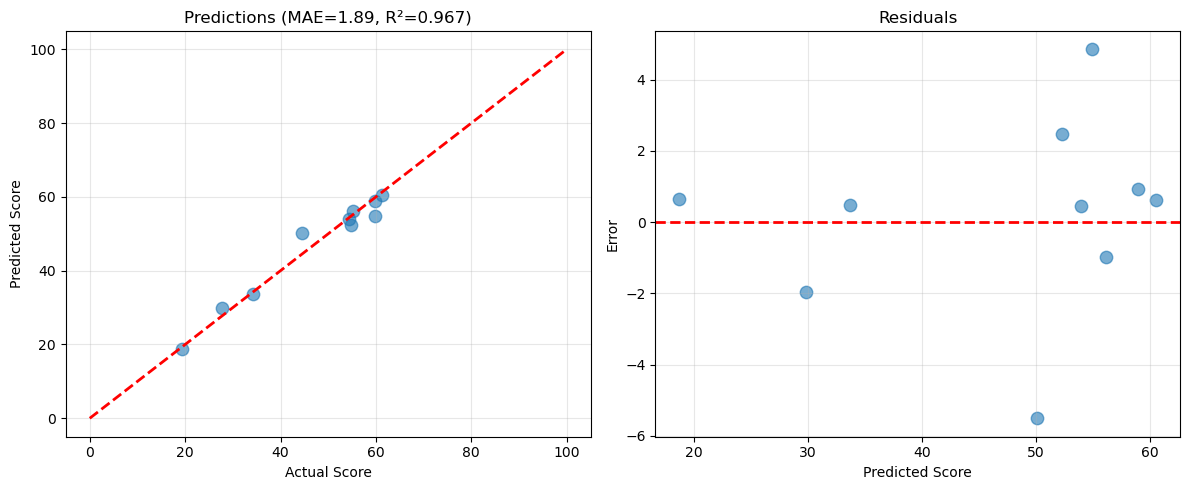

testing : Starlink-like constellation (800km, 53°, 120 sats)
Predicted coverage: 50.5/100


In [21]:
#importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import os

np.random.seed(42)

#set output path
output_path = r"C:\Users\babua\OneDrive\Desktop\sample_repo"
os.makedirs(output_path, exist_ok=True)

#simple coverage calc based on altitude, inclination, number of sats
def calc_coverage(alt, inc, n_sats):
    alt_norm = (alt - 500) / 1500
    
    #polar vs equatorial coverage
    polar = np.sin(np.radians(inc)) ** 2
    equator = np.cos(np.radians(inc)) ** 2
    lat_coverage = 0.6 * polar + 0.4 * equator
    
    #more sats = better coverage but diminishing returns
    sat_effect = np.log10(n_sats + 1) / np.log10(1000)
    
    #altitude sweet spot penalty
    alt_penalty = np.exp(-((alt_norm - 0.3) ** 2) / 0.3)
    
    score = (40 * alt / 2000 + 30 * lat_coverage + 30 * sat_effect) * alt_penalty
    noise = np.random.normal(0, 2)
    
    return np.clip(score + noise, 0, 100)

#data generation
def generate_data(n):
    data = []
    for _ in range(n):
        alt = np.random.uniform(500, 2000)
        inc = np.random.uniform(0, 90)
        sats = np.random.randint(10, 500)
        score = calc_coverage(alt, inc, sats)
        data.append([alt, inc, sats, score])
    return np.array(data)

print("Satellite Coverage ML Demo")

#generating dataset
data = generate_data(110)

#data preparation
X = data[:, :3]
y = data[:, 3]

#data split
X_train, y_train = X[:100], y[:100]
X_test, y_test = X[100:], y[100:]

print(f"Training: {len(X_train)} samples")
print(f"Testing: {len(X_test)} samples")

#machine learning
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)


#evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

#results table
print("\n Predictions:")
print("-"*75)
print(f"{'Altitude':<12} {'Inclin':<12} {'Sats':<10} {'Actual':<12} {'Predicted':<12} {'Error'}")
print("-"*75)
for i in range(len(X_test)):
    alt, inc, sats = X_test[i]
    actual = y_test[i]
    pred = y_pred[i]
    err = abs(actual - pred)
    print(f"{alt:>8.0f}    {inc:>8.1f}    {sats:>6.0f}    {actual:>8.2f}    {pred:>8.2f}    {err:>8.2f}")


#feature importance
print("\n[5] Feature Importance:")
features = ['Altitude', 'Inclination', 'Num_Sats']
for name, imp in zip(features, model.feature_importances_):
    print(f"{name:<15} {imp:.3f}")

#visualization
print("\n[6] Creating plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#predicted vs actual
ax1.scatter(y_test, y_pred, alpha=0.6, s=80)
ax1.plot([0, 100], [0, 100], 'r--', lw=2)
ax1.set_xlabel('Actual Score')
ax1.set_ylabel('Predicted Score')
ax1.set_title(f'Predictions (MAE={mae:.2f}, R²={r2:.3f})')
ax1.grid(True, alpha=0.3)

#residuals
residuals = y_test - y_pred
ax2.scatter(y_pred, residuals, alpha=0.6, s=80)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Score')
ax2.set_ylabel('Error')
ax2.set_title('Residuals')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plot_file = os.path.join(output_path, 'coverage_results.png')
plt.savefig(plot_file, dpi=150)
print(f"Saved: {plot_file}")
plt.show()

#quick test
print("testing : Starlink-like constellation (800km, 53°, 120 sats)")
test = np.array([[800, 53, 120]])
pred = model.predict(test)[0]
print(f"Predicted coverage: {pred:.1f}/100")